# Perturbation Feature Importance

In this file I use perturbation to find out important features from all features in data.

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

Using TensorFlow backend.


In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=False)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 24)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 24)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

24

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

## Model 1

In [22]:
history = History()

model = Sequential()
model.add(LSTM(
         units=8,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
         units=4,
         return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 8)             1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
___________________

In [23]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Instructions for updating:
Use tf.cast instead.
Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 27s 2ms/step - loss: 0.1985 - acc: 0.8450 - val_loss: 0.1450 - val_acc: 0.8653
Epoch 2/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.1317 - acc: 0.8993 - val_loss: 0.0991 - val_acc: 0.9136
Epoch 3/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0913 - acc: 0.9331 - val_loss: 0.0605 - val_acc: 0.9346
Epoch 4/100
14157/14157 [==============================] - 23s 2ms/step - loss: 0.0697 - acc: 0.9467 - val_loss: 0.0491 - val_acc: 0.9549
Epoch 5/100
14157/14157 [==============================] - 23s 2ms/step - loss: 0.0621 - acc: 0.9515 - val_loss: 0.0547 - val_acc: 0.9244
Epoch 6/100
14157/14157 [==============================] - 24s 2ms/step - loss: 0.0570 - acc: 0.9531 - val_loss: 0.0634 - val_acc: 0.9257
Epoch 7/100
14157/14157 [==============================] - 24s 2ms/step - l

Text(0.5, 1.0, 'Loss')

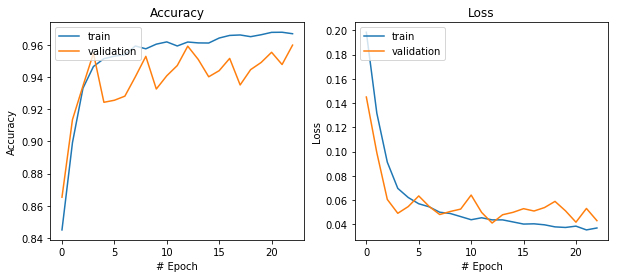

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

In [27]:
def print_results(y_test, y_pred):
    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

F1 Score:  0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.91      1.00      0.95        30

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

Area under curve :  0.9785714285714286 



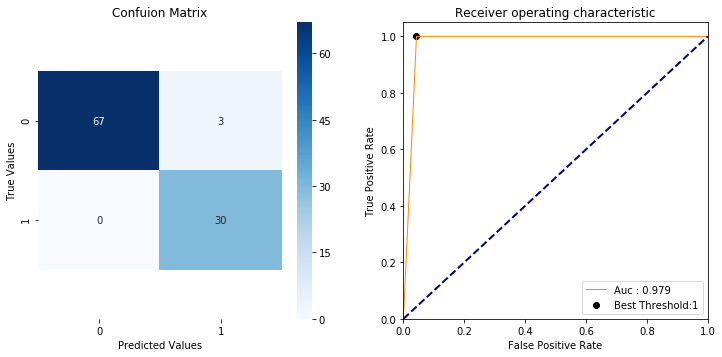

In [28]:
y_pred = model.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [26]:
confusion_matrix(y_train, model.predict_classes(x_train))

array([[10500,   231],
       [  176,  4824]], dtype=int64)

In [100]:
train_probs = model.predict_proba(x_train)

### Perturbation 

In [30]:
y_true['failure_probability'] = model.predict_proba(x_test)
y_true.head()

,RUL,UnitNumber,failure,failure_probability
0,112,0,0,0.000473
1,98,1,0,0.000634
2,69,2,0,0.155520
3,82,3,0,0.004428
4,91,4,0,0.005056


In [115]:
feature_importance = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict_proba(new_x)
    
    effect = mean_squared_error(y_true.failure_probability, perturbed_out)
    feature_importance = feature_importance.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

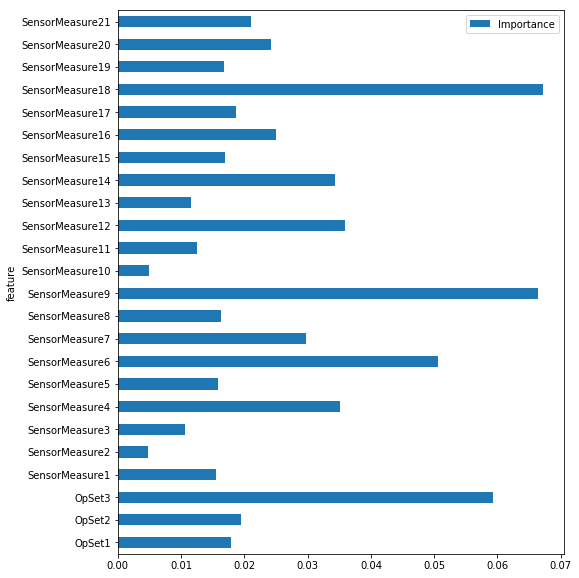

In [116]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance.plot.barh(x = 'feature', y = 'Importance', ax = ax)

## Model 2

In [117]:
len(feats)

24

In [118]:
history = History()

model2 = Sequential()
model2.add(LSTM(
         units=50,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model2.add(Dropout(0.5))
model2.add(LSTM(
         units=25,
         return_sequences=False))
model2.add(Dropout(0.5))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 50)            15000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 22,626
Trainable params: 22,626
Non-trainable params: 0
_________________________________________________________________


In [119]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100
14157/14157 [==============================] - 31s 2ms/step - loss: 0.1162 - acc: 0.8962 - val_loss: 0.0532 - val_acc: 0.9435
Epoch 2/100
14157/14157 [==============================] - 25s 2ms/step - loss: 0.0712 - acc: 0.9365 - val_loss: 0.0507 - val_acc: 0.9460
Epoch 3/100
14157/14157 [==============================] - 25s 2ms/step - loss: 0.0619 - acc: 0.9441 - val_loss: 0.0484 - val_acc: 0.9428
Epoch 4/100
14157/14157 [==============================] - 22s 2ms/step - loss: 0.0532 - acc: 0.9479 - val_loss: 0.0537 - val_acc: 0.9269
Epoch 5/100
14157/14157 [==============================] - 25s 2ms/step - loss: 0.0512 - acc: 0.9507 - val_loss: 0.0576 - val_acc: 0.9314
Epoch 6/100
14157/14157 [==============================] - 25s 2ms/step - loss: 0.0459 - acc: 0.9529 - val_loss: 0.0655 - val_acc: 0.9225
Epoch 7/100
14157/14157 [==============================] - 25s 2ms/step - loss: 0.0438 - acc: 0.9566 - val_loss: 0.0374 - v

Text(0.5, 1.0, 'Loss')

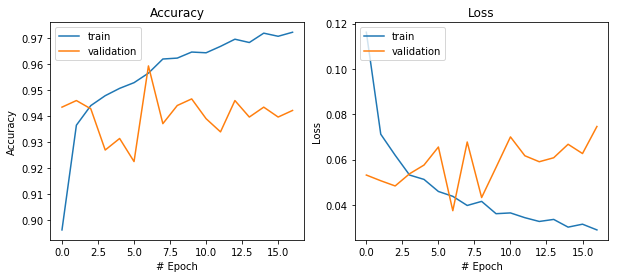

In [120]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.94      1.00      0.97        30

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9857142857142857 



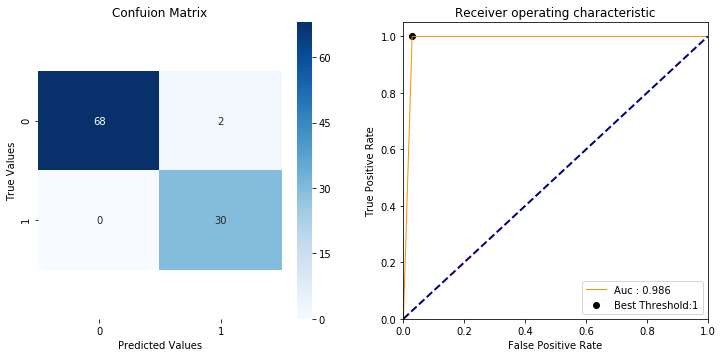

In [121]:
y_pred = model2.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [122]:
confusion_matrix(y_train, model2.predict_classes(x_train))

array([[10409,   322],
       [   76,  4924]], dtype=int64)

In [123]:
test_probs2 = model2.predict_proba(x_test)

### Perturbation 

In [124]:
feature_importance2 = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model2.predict_proba(new_x)
    
    effect = mean_squared_error(test_probs2, perturbed_out)
    feature_importance2 = feature_importance2.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

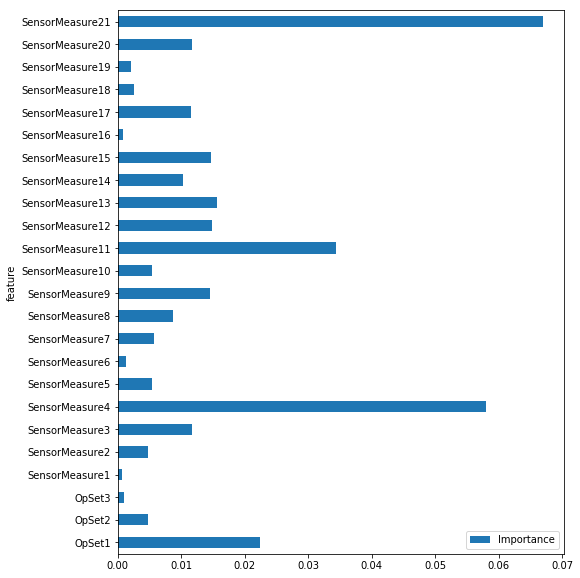

In [125]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)

In [ ]:
x_train

In [131]:
import shap

random_ind = np.random.choice(x_train.shape[0], 1000, replace = False)
data = x_train[random_ind[0:1000]]

DE = shap.DeepExplainer(model, data)
shap_values = DE.shap_values(x_test)

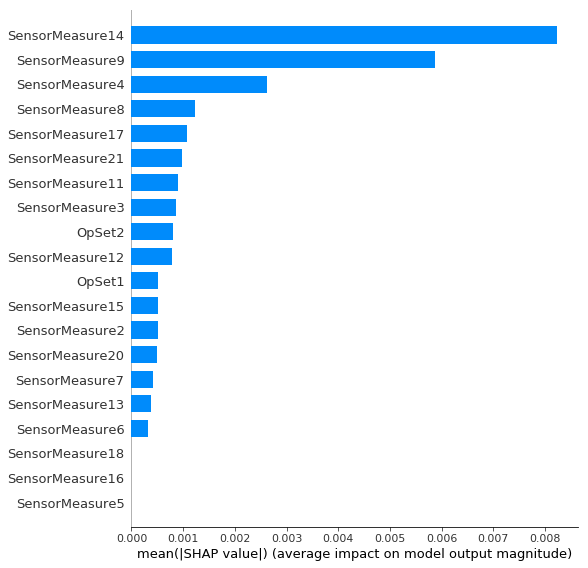

In [168]:
shap.initjs()
shap.summary_plot(shap_values[0][99], x_test[0], feature_names=feats, plot_type = 'bar')

In [139]:
len(shap_values[0])

100

In [148]:
shap_values[0][0][0]

array([ 8.55830110e-06,  2.11615576e-05, -2.54156788e-04, -6.84529637e-06,
        1.41990727e-05, -2.81624888e-05,  1.34662018e-04, -3.88520391e-04,
        1.50120658e-04,  1.37611656e-04,  1.00409912e-04,  4.34515823e-04,
        1.20333576e-04,  3.54041024e-05,  1.52769378e-04, -2.17409570e-04,
        6.02071704e-04,  4.28173736e-05, -4.12315546e-04,  9.89066375e-06,
       -7.86644721e-04, -2.06910620e-04, -2.80657383e-05,  4.96244276e-05])

In [170]:
len(shap_values[0])

100

In [177]:
shap_val = np.array(shap_values)
print(shap_val.shape)
shap_val = np.reshape(shap_val, (shap_val.shape[1], shap_val.shape[2], shap_val.shape[3]))
shap_abs = np.abs(shap_val)
sum_0 = np.sum(shap_abs, axis = 0)
print(sum_0.shape)

(1, 100, 50, 24)
(50, 24)


<BarContainer object of 24 artists>

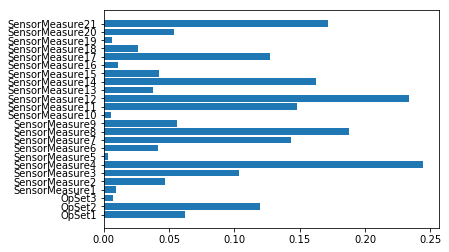

In [180]:
plt1 = plt.subplot()
plt1.barh(feats, sum_0[1])